In [50]:
# !pip install timm medmnist scikit-learn

In [51]:
# -------------------- Setup --------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import timm
import numpy as np
import random
from sklearn.metrics import balanced_accuracy_score
from medmnist import INFO, BloodMNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


In [52]:
# -------------------- Config --------------------
SEED = 42
USE_SUBSET = True      # Set to True to use a small subset of data
TRAIN_SUBSET_SIZE = 100  # smaller for faster training
TEST_SUBSET_SIZE = 20    # optionally reduced, but still enough to validate
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [53]:
# -------------------- Data --------------------
info = INFO['bloodmnist']
n_classes = len(info['label'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
root = './data'

train_dataset = BloodMNIST(root=root, split='train', transform=transform, download=True)
test_dataset = BloodMNIST(root=root, split='test', transform=transform, download=True)

# Optional subset (for debugging/faster runs)
if USE_SUBSET:
    indices = list(range(len(train_dataset)))
    subset_indices = indices[:TRAIN_SUBSET_SIZE]
    train_dataset = Subset(train_dataset, subset_indices)
    # for test dataset 
    test_indices = list(range(len(test_dataset)))
    test_subset_indices = test_indices[:TEST_SUBSET_SIZE]
    test_dataset = Subset(test_dataset, test_subset_indices)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: ./data\bloodmnist.npz
Using downloaded and verified file: ./data\bloodmnist.npz


In [54]:
# -------------------- SLViT --------------------
class SLViT(nn.Module):
    def __init__(self, num_classes, diff_privacy=False, mean=0, std=1):
        super().__init__()
        self.diff_privacy = diff_privacy
        self.mean = mean
        self.std = std

        self.vit = timm.create_model('vit_base_patch16_224', pretrained=False)
        self.vit.head = nn.Identity()

        self.patch_embed = nn.Conv2d(3, 768, kernel_size=16, stride=16)
        self.transformer_blocks = self.vit.blocks
        self.cls_token = self.vit.cls_token
        self.pos_embed = self.vit.pos_embed
        self.pos_drop = self.vit.pos_drop
        self.norm = self.vit.norm

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        # CLIENT
        x = self.patch_embed(x)                          # (B, 768, 14, 14)
        x = x.flatten(2).transpose(1, 2)                 # (B, 196, 768)

        if self.diff_privacy:
            x += torch.randn_like(x) * self.std + self.mean

        # SERVER
        B = x.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)    # (B, 1, 768)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.norm(x)
        cls = x[:, 0]                                    # (B, 768)

        # CLIENT
        out = self.mlp_head(cls)                         # (B, num_classes)
        return out


In [55]:
# -------------------- Training --------------------
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_labels, all_preds = [], []

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.squeeze().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.append(outputs.argmax(1).cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = balanced_accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


In [56]:
# -------------------- Evaluation --------------------
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.squeeze().to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.append(outputs.argmax(1).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = balanced_accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


In [57]:
# -------------------- Run --------------------
model = SLViT(num_classes=n_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"✅ Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")



🔁 Epoch 1/10


✅ Train Acc: 0.1209 | Test Acc: 0.1429

🔁 Epoch 2/10


✅ Train Acc: 0.1341 | Test Acc: 0.1429

🔁 Epoch 3/10


✅ Train Acc: 0.0897 | Test Acc: 0.1429

🔁 Epoch 4/10


✅ Train Acc: 0.1314 | Test Acc: 0.1429

🔁 Epoch 5/10


✅ Train Acc: 0.1591 | Test Acc: 0.1429

🔁 Epoch 6/10


✅ Train Acc: 0.1693 | Test Acc: 0.1429

🔁 Epoch 7/10


✅ Train Acc: 0.2324 | Test Acc: 0.1429

🔁 Epoch 8/10


✅ Train Acc: 0.2439 | Test Acc: 0.1429

🔁 Epoch 9/10


✅ Train Acc: 0.1471 | Test Acc: 0.1429

🔁 Epoch 10/10


✅ Train Acc: 0.2576 | Test Acc: 0.1429


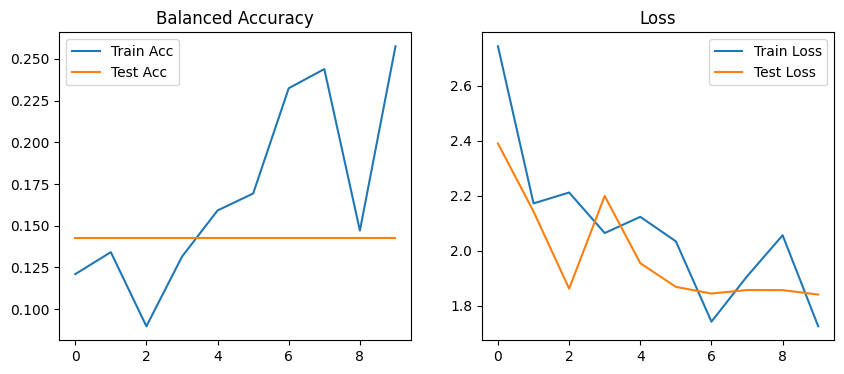

In [58]:
# -------------------- Plot --------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Balanced Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.show()
